# **Anomaly Detection in Time Series Data**

## Ambient Intelligence and Domotics
### Ulysse Duvillier

This notebook aims to identify anomalous patterns within a time series dataset by building models trained on normal activity data and testing them on both normal and (fall detection).

#### Dataset overview

The MobiAct Dataset is designed for the analysis of human activities, particularly focusing on different types of falls and daily living activities (ADLs). The dataset includes data from 66 participants performing falls and 19-66 participants performing various ADLs.


In [1]:
import numpy as np
import pandas as pd
import os
import glob
import random

# Preprocessing

Explanation
Directory Path: The data_dir variable should be set to the path of the main directory containing your annotated data directories.

Reading Files: We loop through each activity directory within the main directory and then loop through each file in these directories. For each file, we extract data (activity type, sensor type, participant ID, and trial number) from the filename.

Reading Data: Each CSV file is read into a DataFrame using pd.read_csv. No header is present in the data files (header=None).

Combining Data: Data columns are added to each DataFrame, and these DataFrames are appended to a list. All DataFrames in the list are then concatenated into a single DataFrame using pd.concat.

Saving: The combined DataFrame is saved to a new CSV file named combined_mobiact_dataset.csv.

We can should how much % of the dataset we select in order to speed up the computation.

In [2]:
def load_and_combine_data(data_folder, sample_percentage=100):
    # Recursively search for all activity folders
    activity_folders = glob.glob(os.path.join(data_folder, '*'))
    
    # Create an empty list to store the data
    all_data = []

    # Iterate through each activity folder
    for activity_folder in activity_folders:
        print(f"Processing activity folder: {activity_folder}")
        
        # Search for all CSV files within the current activity folder
        data_files = glob.glob(os.path.join(activity_folder, '*.csv'))
        
        # Shuffle the list of data files to ensure random sampling
        random.shuffle(data_files)
        
        # Calculate the number of files to load based on the sample percentage
        num_files_to_load = int(len(data_files) * sample_percentage / 100)
        
        # Iterate through each CSV file in the current activity folder
        for i, file in enumerate(data_files):
            if i < num_files_to_load:
                file_path = os.path.abspath(file)
                data = pd.read_csv(file_path)
                
                # Extract metadata from the filename
                parts = os.path.basename(file).split('_')
                activity_type = parts[0]
                sensor_type = parts[1]
                participant_id = parts[2]
                trial_no = parts[3].split('.')[0]
                
                # Add metadata columns to the DataFrame
                data['Activity Type'] = activity_type
                data['Sensor Type'] = sensor_type
                data['Participant ID'] = participant_id
                data['Trial No'] = trial_no
                
                all_data.append(data)
                #### print(f"Loaded {i+1}/{num_files_to_load} files for this activity.")
    
    # Concatenate all the loaded data into a single DataFrame
    combined_data = pd.concat(all_data, ignore_index=True)
    
    return combined_data

# Define the path to the annotated data folder
data_folder = '/kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data'
sample_percentage = 3  # Load only 30% of the dataset

# Load and combine data from all activity folders with sampling
combined_data = load_and_combine_data(data_folder, sample_percentage)

# Export combined data to a CSV file
output_file = 'combined_mobiact_dataset.csv'
combined_data.to_csv(output_file, index=False)
print(f"Combined data exported to {output_file}")

Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/FOL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/CSO
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STU
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SDL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SLH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SCH
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/STN
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/SBE
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated Data/WAL
Processing activity folder: /kaggle/input/mobiact-dataset-v2/MobiAct_Dataset_v2.0/Annotated

## Load the Combined Dataset
We'll load the dataset using pandas.

In [3]:
import pandas as pd

# Load the combined dataset
file_path = '/kaggle/working/combined_mobiact_dataset.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()

,timestamp,rel_time,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,azimuth,pitch,roll,label,Activity Type,Sensor Type,Participant ID,Trial No
0,17976673115000,0.000000,1.507764,9.850665,0.036053,-0.022297,-0.030238,0.018326,28.222271,-32.821297,37.204815,STD,FOL,67,1,annotated
1,17976678296000,0.005181,1.513477,9.853894,0.039779,-0.021686,-0.028711,0.026573,28.696733,-33.461320,36.999190,STD,FOL,67,1,annotated
2,17976683128000,0.010013,1.518806,9.856906,0.043254,-0.018326,-0.014966,0.013439,29.165950,-34.101833,36.783450,STD,FOL,67,1,annotated
3,17976688105000,0.014990,1.524294,9.860008,0.046834,-0.006109,-0.001222,0.019242,29.619194,-34.732983,36.569077,STD,FOL,67,1,annotated
4,17976693168000,0.020053,1.529877,9.863164,0.050475,-0.017104,-0.000611,0.025656,30.066778,-35.357040,36.348640,STD,FOL,67,1,annotated


## Create a Fall column

In [4]:
# list of fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']

# Create a new column 'Fall' to indicate true/false for falls
df['Fall'] = df['Activity Type'].isin(fall_types)

# Convert 'Fall' column to integer (0 for false, 1 for true)
df['Fall'] = df['Fall'].astype(int)

# Print to see Fall
print(df)

             timestamp  rel_time     acc_x     acc_y     acc_z    gyro_x  \
0       17976673115000  0.000000  1.507764  9.850665  0.036053 -0.022297   
1       17976678296000  0.005181  1.513477  9.853894  0.039779 -0.021686   
2       17976683128000  0.010013  1.518806  9.856906  0.043254 -0.018326   
3       17976688105000  0.014990  1.524294  9.860008  0.046834 -0.006109   
4       17976693168000  0.020053  1.529877  9.863164  0.050475 -0.017104   
...                ...       ...       ...       ...       ...       ...   
294711    343020398000  5.674335 -5.579505  8.121340 -0.242985 -0.070860   
294712    343025442000  5.679379 -5.546397  8.155684 -0.235927 -0.060476   
294713    343030428000  5.684365 -5.512387  8.179977 -0.221351 -0.047037   
294714    343035399000  5.689336 -5.480235  8.195321 -0.205840 -0.051924   
294715    343040435000  5.694372 -5.452562  8.186097 -0.187391 -0.043066   

          gyro_y    gyro_z     azimuth       pitch       roll label  \
0      -0.030238

## Check the Structure and Summary Statistics
We'll examine the structure and summary statistics to understand the dataset better.

In [5]:
# Display basic information about the dataset
df.info()

# Display summary statistics
df.describe()

# Display the unique activities in the dataset
print("\n\n\n Activity Type")
df['Activity Type'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294716 entries, 0 to 294715
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       294716 non-null  int64  
 1   rel_time        294716 non-null  float64
 2   acc_x           294716 non-null  float64
 3   acc_y           294716 non-null  float64
 4   acc_z           294716 non-null  float64
 5   gyro_x          294716 non-null  float64
 6   gyro_y          294716 non-null  float64
 7   gyro_z          294716 non-null  float64
 8   azimuth         294716 non-null  float64
 9   pitch           294716 non-null  float64
 10  roll            294716 non-null  float64
 11  label           294716 non-null  object 
 12  Activity Type   294716 non-null  object 
 13  Sensor Type     294716 non-null  int64  
 14  Participant ID  294716 non-null  int64  
 15  Trial No        294716 non-null  object 
 16  Fall            294716 non-null  int64  
dtypes: float64

array(['FOL', 'CSO', 'STU', 'SDL', 'SCH', 'STN', 'WAL', 'CSI', 'FKL',
       'JUM', 'BSC', 'STD', 'JOG', 'CHU'], dtype=object)

## Visualize the Distribution of Activities

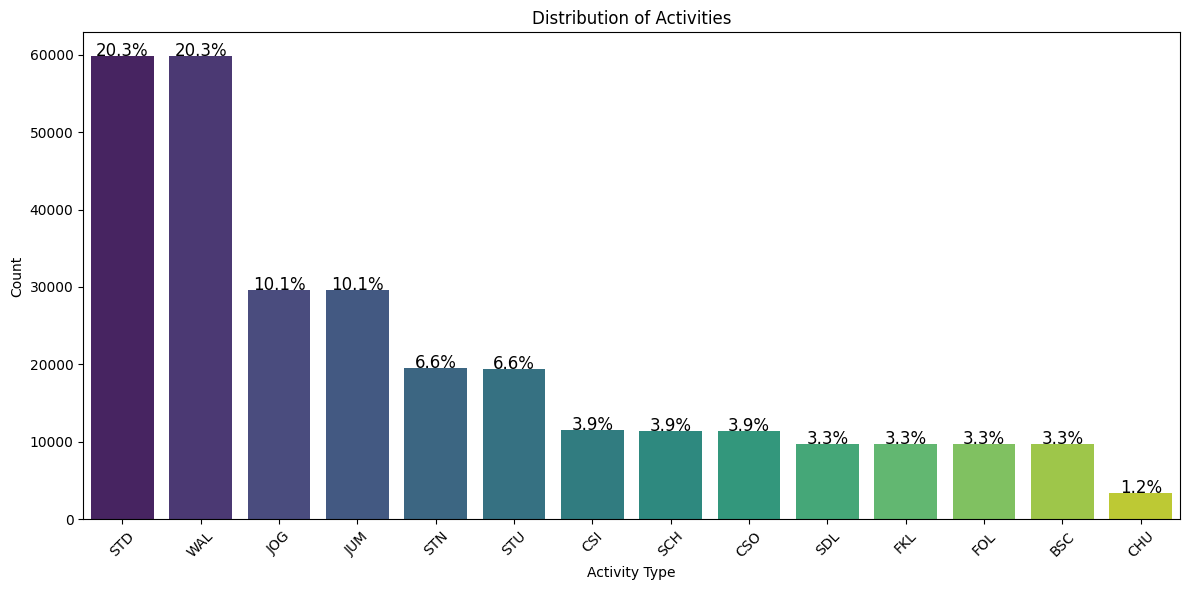

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each activity type
activity_counts = df['Activity Type'].value_counts()

# Calculate the percentage of each activity type
activity_percentages = (activity_counts / activity_counts.sum()) * 100

# Create a bar plot of the activity distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values, palette='viridis')

# Add percentage labels on top of each bar
for i, (count, percentage) in enumerate(zip(activity_counts.values, activity_percentages)):
    plt.text(i, count + 0.5, f'{percentage:.1f}%', ha='center', fontsize=12)

# Set plot labels and title
plt.title('Distribution of Activities')
plt.xlabel('Activity Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


## Evaluate the Quality of the Dataset
We'll check for missing values and inconsistencies to assess the dataset's quality.

In [7]:
# Check for missing values
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

# Check for duplicates
duplicate_rows = df.duplicated().sum()

# Display the number of duplicate rows
duplicate_rows

# Check the balance of activities
activity_balance = df['Activity Type'].value_counts(normalize=True) * 100

# Display the balance of activities
activity_balance

Activity Type
STD    20.316169
WAL    20.284613
JOG    10.066640
JUM    10.050693
STN     6.625022
STU     6.605681
CSI     3.919706
SCH     3.860666
CSO     3.857951
SDL     3.320824
FKL     3.316752
FOL     3.313359
BSC     3.303859
CHU     1.158064
Name: proportion, dtype: float64

## Visualize Sensor Data for Each Activity
We'll plot sensor data for a few activities to get an idea of the data quality and patterns.

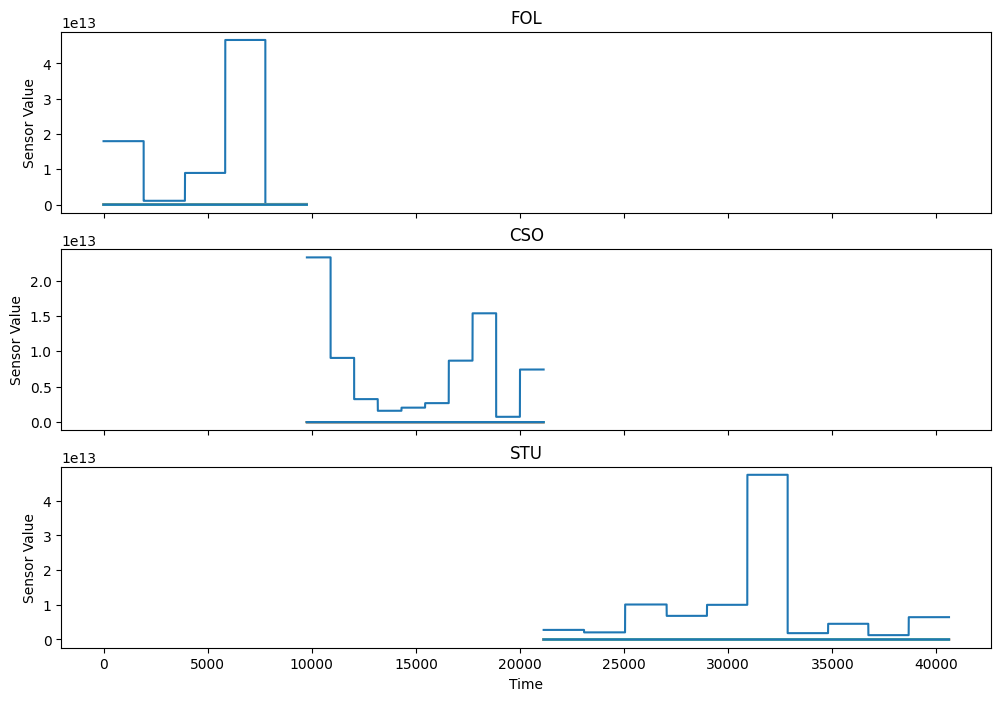

In [8]:
# Sample a few activities to plot
sample_activities = df['Activity Type'].unique()[:3]

# Plot sensor data for each sampled activity
fig, axes = plt.subplots(len(sample_activities), 1, figsize=(12, 8), sharex=True)

for i, activity in enumerate(sample_activities):
    activity_data = df[df['Activity Type'] == activity].iloc[:, :-4]  # Exclude metadata columns
    activity_data.plot(ax=axes[i], title=activity, legend=False)
    axes[i].set_ylabel('Sensor Value')

plt.xlabel('Time')
plt.show()

**Housekeeping**

Checking for blank values, checking Data Types etc.

In [9]:
def overview(df: pd.DataFrame, timestamp_col: str = None) -> None:
    print('Null Count:\n', df.isnull().sum(),'\n')
    print('Data Types:\n', df.dtypes)
    
    if timestamp_col is not None:
        print('\nDate Range:\n\nStart:\t',df[timestamp_col].min())
        print('End:\t',df[timestamp_col].max())
        print('Days:\t',(df[timestamp_col].max() - df[timestamp_col].min()))

        overview(df, timestamp_col='timestamp')

### Pair for each fall types

Try to analyze the correlation between different features.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Extract fall data based on fall types
fall_types = ['FOL', 'FKL', 'BSC', 'SDL']
fall_data = df[df['Activity Type'].isin(fall_types)]

# Set up the figure and axes for plotting
num_fall_types = len(fall_types)


if True == False :
    # Create a pair plot for each fall type
    for i, fall_type in enumerate(fall_types):
        fall_type_data = fall_data[fall_data['Activity Type'] == fall_type]

        # Select relevant features for plotting
        features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

        # Create a PairGrid
        g = sns.PairGrid(fall_type_data[features], diag_sharey=False, corner=False)
        g.map_upper(sns.scatterplot, alpha=0.5)
        g.map_lower(sns.kdeplot, fill=True)
        g.map_diag(sns.histplot)

        # Set the title and adjust subplot positioning
        axes[i].set_title(f"Fall Type: {fall_type}")
        g.fig.suptitle(f"Fall Type: {fall_type}", y=1.02) 
        g.fig.tight_layout() 

    plt.tight_layout()
    plt.show()


# Pipeline 

#### gpu availability : cuda

In [11]:
import torch
import torch.cuda
import torch.nn.functional as F

# Set the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Pipeline Explanation

#### What you suggested 
- 80% of normal activities to train the baseline (as one-class SVM or simple auto encoder) and one advanced technique (as variational AE or masked AE)
- Test on the fall data + 20% of normal activities
- Compare the reconstruction error and see if there is a separation between the data reconstructed from the normal activities and the one of the falls.

#### What i did

* Data Preparation: We split the normal activities into 80% training and 20% for testing. Fall data is added to the test set.
* LocalOutlierFactor: Trained on the normal activities and used to predict anomalies in the test set.
* VAE: A Variational Autoencoder model is trained on normal data and evaluated on both normal and fall data to calculate the reconstruction error.
* Comparison: The reconstruction errors of normal vs. fall activities are plotted, and we expect a separation between them.

#### Why ?

- I did use LOF instead of OneclassSVM as you suggested because, LocalOutlierFactor can handle more feature and it s "fast". 
- OneclassSVM as a limit of 10 features with scikitlearn and there is 12 interesting features in the dataset. 
- Also, I could not use gpu computing for this as libraries where not compatible with the different types of kaggle's gpus.



In [12]:
# import 

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm  # For progress tracking
from sklearn.decomposition import PCA

from sklearn.neighbors import LocalOutlierFactor

## preprocessing for baseline



In [13]:
## Drop columns
try : df = df.drop(['label', 'Activity Type', 'Trial No', 'Sensor Type'], axis=1)
except : None
    
# Step 1: Split Data
df_normal = df[df['Fall'] == 0]
df_fall = df[df['Fall'] == 1]

# 80% of normal data for training, 20% for testing
train_data_normal, test_data_normal = train_test_split(df_normal, test_size=0.2, random_state=42)

# Test set includes 20% normal + all fall data
test_data = pd.concat([test_data_normal, df_fall])


X_train = train_data_normal.drop('Fall', axis=1)
y_train = train_data_normal['Fall']  

X_test = test_data.drop('Fall', axis=1)
y_test = test_data['Fall']  


# Step 2: Data normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Step 2: Data normalization')

Step 2: Data normalization


#### Check proportion

In [14]:
total_samples = len(df)
num_anomalies = np.sum(df['Fall'] == 1)
proportion_anomalies = num_anomalies / total_samples

print(f"Total samples: {total_samples}")
print(f"Number of anomalies: {num_anomalies}")
print(f"Proportion of anomalies: {proportion_anomalies:.2f}")

Total samples: 294716
Number of anomalies: 39064
Proportion of anomalies: 0.13


## LocalOutlierFactor - baseline

In [15]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train LOF and get scores
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1, novelty=True)
lof.fit(X_train_pca)

# Predict with LOF
y_pred_lof = lof.predict(X_test_pca)

# Convert -1 to 1 (fall) and 1 to 0 (normal)
y_pred_lof = np.where(y_pred_lof == -1, 1, 0)

# Calculate reconstruction error for LOF
# LOF does not provide direct reconstruction error like autoencoders; we use decision function values
lof_scores = -lof.decision_function(X_test_pca)  # Negative sign because higher scores are better

# Compute a threshold based on LOF scores for normal activities
threshold_lof = np.percentile(lof_scores[y_test == 0], 99)  #95 base

# Classify based on the LOF score
y_pred_lof = np.where(lof_scores > threshold_lof, 1, 0)  # 1 for fall (anomaly), 0 for normal

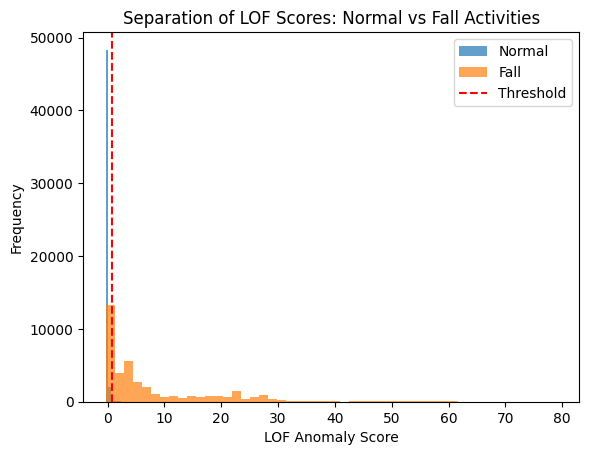

Accuracy (LOF): 0.8871
Precision (LOF): 0.9829
Recall (LOF): 0.7524
F1-Score (LOF): 0.8523
Confusion Matrix (LOF):
[[50619   512]
 [ 9672 29392]]


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Plot histograms for normal and fall activities
plt.hist(lof_scores[y_test == 0], bins=50, alpha=0.7, label="Normal")
plt.hist(lof_scores[y_test == 1], bins=50, alpha=0.7, label="Fall")
plt.axvline(x=threshold_lof, color='r', linestyle='--', label="Threshold")
plt.xlabel("LOF Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.title("Separation of LOF Scores: Normal vs Fall Activities")
plt.show()

# Metrics
accuracy_lof = accuracy_score(y_test, y_pred_lof)
precision_lof = precision_score(y_test, y_pred_lof)
recall_lof = recall_score(y_test, y_pred_lof)
f1_lof = f1_score(y_test, y_pred_lof)

print(f"Accuracy (LOF): {accuracy_lof:.4f}")
print(f"Precision (LOF): {precision_lof:.4f}")
print(f"Recall (LOF): {recall_lof:.4f}")
print(f"F1-Score (LOF): {f1_lof:.4f}")

# Confusion Matrix
conf_matrix_lof = confusion_matrix(y_test, y_pred_lof)
print("Confusion Matrix (LOF):")
print(conf_matrix_lof)


#### try 3D plot 

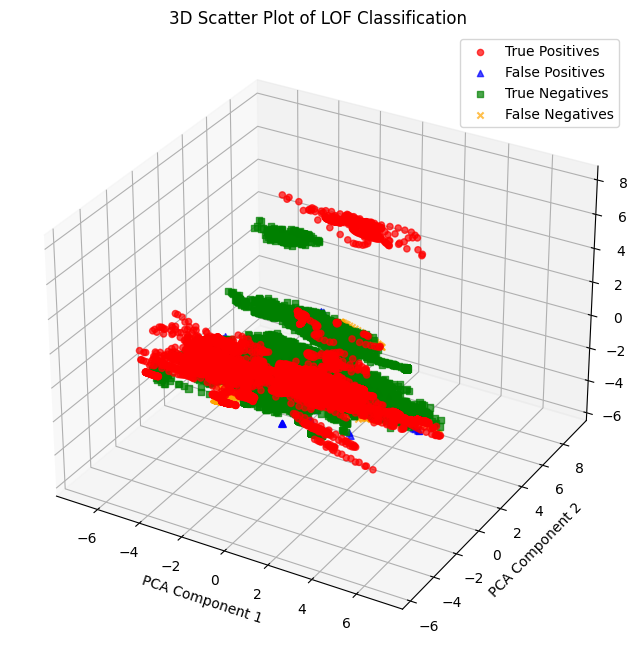

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduce dimensionality to 3D for visualization
pca_3d = PCA(n_components=3)
X_test_pca_3d = pca_3d.fit_transform(X_test_scaled)

# Categorize points for different classes
true_positives = (y_test == 1) & (y_pred_lof == 1)  # Correctly classified anomalies
false_positives = (y_test == 0) & (y_pred_lof == 1)  # Incorrectly classified normal as anomalies
true_negatives = (y_test == 0) & (y_pred_lof == 0)  # Correctly classified normal
false_negatives = (y_test == 1) & (y_pred_lof == 0)  # Incorrectly classified anomalies as normal

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter points with different colors
ax.scatter(X_test_pca_3d[true_positives, 0], X_test_pca_3d[true_positives, 1], X_test_pca_3d[true_positives, 2], 
           c='red', label='True Positives', marker='o', alpha=0.7)
ax.scatter(X_test_pca_3d[false_positives, 0], X_test_pca_3d[false_positives, 1], X_test_pca_3d[false_positives, 2], 
           c='blue', label='False Positives', marker='^', alpha=0.7)
ax.scatter(X_test_pca_3d[true_negatives, 0], X_test_pca_3d[true_negatives, 1], X_test_pca_3d[true_negatives, 2], 
           c='green', label='True Negatives', marker='s', alpha=0.7)
ax.scatter(X_test_pca_3d[false_negatives, 0], X_test_pca_3d[false_negatives, 1], X_test_pca_3d[false_negatives, 2], 
           c='orange', label='False Negatives', marker='x', alpha=0.7)

# Label axes
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Add legend
ax.legend(loc='upper right')

# Show plot
plt.title('3D Scatter Plot of LOF Classification')
plt.show()


#### results


for lof, we obtain great resultat as the distinction of the error reconstruct of the normal and fall activities is well define. 

The accuracy is pretty high (93%) so i set the treshold with high values as we are pretty confident on the result.

## Variational Autoencoder

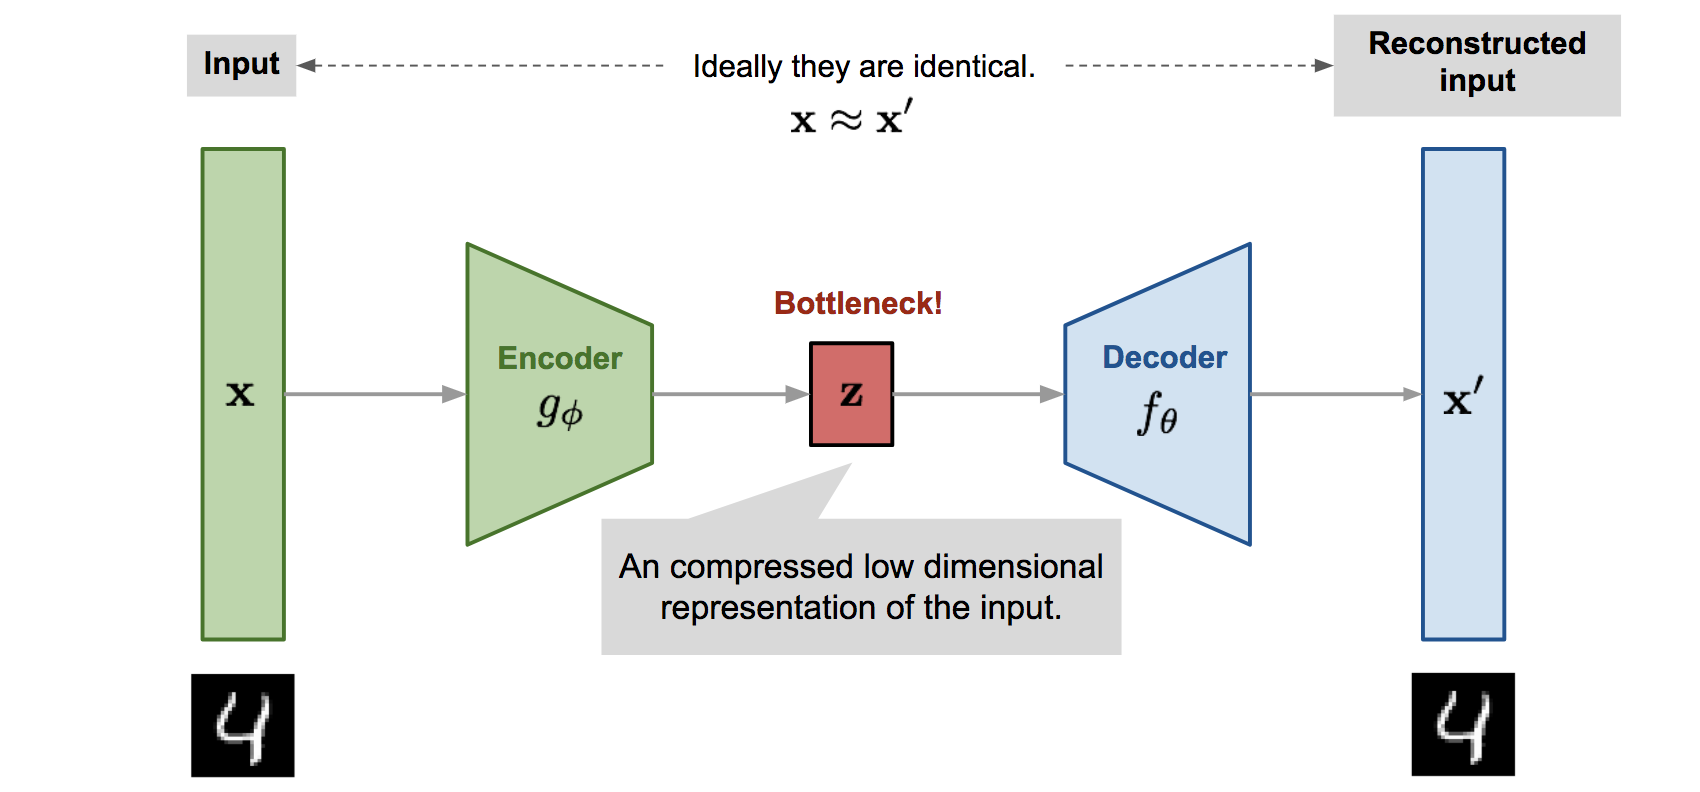

#### VAE Model

In [18]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder: Input to Latent Space
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )
        
        # Latent variables
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder: Latent Space to Output
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, input_dim),
            nn.Sigmoid()  # Output between 0 and 1
        )
    
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.mu_layer(hidden)
        logvar = self.logvar_layer(hidden)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random sample from normal distribution
        return mu + eps * std  # Reparameterization trick
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

#### VAE training

In [19]:
# Instantiate the model
input_dim = X_train_scaled.shape[1]
print(input_dim)
hidden_dim = 32
latent_dim = 4
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Optimizer and criterion
optimizer = optim.Adam(vae.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.MSELoss()

# Define the loss function with KL divergence
def loss_function(recon_x, x, mu, logvar):
    MSE = criterion(recon_x, x)  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return MSE + KLD

# VAE Training Setup
vae.train()
num_epochs = 500

X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    optimizer.zero_grad()
    recon_batch, mu, logvar = vae(X_train_tensor)
    loss = loss_function(recon_batch, X_train_tensor, mu, logvar)
    loss.backward()
    optimizer.step()

# VAE Testing (Reconstruction Error)
vae.eval()
with torch.no_grad():
    recon_test, _, _ = vae(X_test_tensor)
    recon_error_vae = torch.mean((recon_test - X_test_tensor) ** 2, dim=1).cpu().numpy()

# Compare Reconstruction Errors
print(f"Reconstruction Error (VAE): {np.mean(recon_error_vae)} \n")

# Determine a threshold for classification
threshold = np.percentile(recon_error_vae[y_test == 0], 80)

# Classify based on reconstruction error
y_pred_vae = np.where(recon_error_vae > threshold, 1, 0)  # 1 for anomaly, 0 for normal

12


Training Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Reconstruction Error (VAE): 1.4245855808258057 



#### VAE Metrics

Accuracy (VAE): 0.7261
Precision (VAE): 0.7063
Recall (VAE): 0.6294
F1-Score (VAE): 0.6656
Confusion Matrix (VAE):
[[40905 10226]
 [14477 24587]]


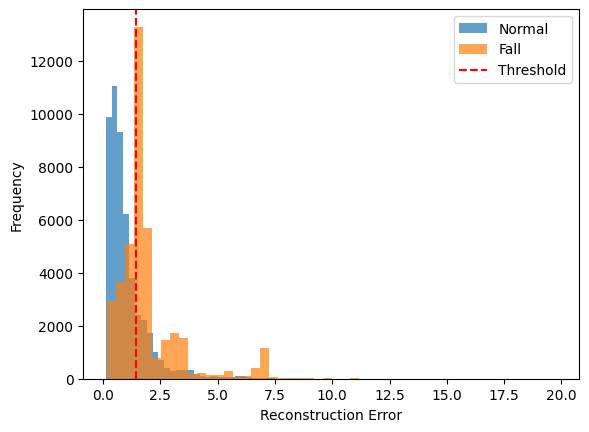

In [20]:
########################  Metrics ########################

accuracy = accuracy_score(y_test, y_pred_vae)
precision = precision_score(y_test, y_pred_vae)
recall = recall_score(y_test, y_pred_vae)
f1 = f1_score(y_test, y_pred_vae)

print(f"Accuracy (VAE): {accuracy:.4f}")
print(f"Precision (VAE): {precision:.4f}")
print(f"Recall (VAE): {recall:.4f}")
print(f"F1-Score (VAE): {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_vae)
print("Confusion Matrix (VAE):")
print(conf_matrix)

# Visualize the separation between normal and fall activities
plt.hist(recon_error_vae[y_test == 0], bins=50, alpha=0.7, label="Normal")
plt.hist(recon_error_vae[y_test == 1], bins=50, alpha=0.7, label="Fall")
plt.axvline(x=threshold, color='r', linestyle='--', label="Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

#### Results 

For VAE, the results are less convincing. We can observe a difference between the error reconstruction of normal and falls activity but not sharply. The other metrics such as the accuracy(70%) are pretty low compare to the LOF model. 


I might have overcomplicated the model in order to improve the accuracy, but resulting in a too complex models for the problem.

# Train CNNs Models

Now, i want to try complex models design for time series such as LSTM and GRU. I added a mutli head self attention layer to catch the pattern of the datas. 

Both LSTM and GRU models has the same structure of design : 
- Those models first embeds the input data, processes it through a GRU/LSTM layer to capture sequential dependencies, refines the features using self-attention, and finally uses fully connected layers to produce the final prediction.
- The difference is on the lstm and gru function.

In [21]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn

## Multi Head Self-Attention module

In [22]:
class MHSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MHSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "Embedding dimension must be divisible by number of heads"

        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attn = F.softmax(scores, dim=-1)
        context = torch.matmul(attn, V)

        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.embed_dim)

        return self.out(context)

## LSTM model

In [23]:
class LSTM_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim):
        super(LSTM_SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.self_attn = MHSelfAttention(embedding_dim, num_heads)
        
        fc_layer_sizes = [hidden_dim] + fc_layers
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(fc_layer_sizes[:-1], fc_layer_sizes[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())
        self.output_layer = nn.Linear(fc_layers[-1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.LSTM(x)
        x = self.self_attn(x)
        
        x = x[:, -1, :]  # Use the output of the last timestep or aggregate as needed
        
        for layer in self.fc_layers:
            x = layer(x)
        
        x = self.output_layer(x).squeeze(-1)  # Ensure output shape is [batch_size]
        
        return x

## GRU model

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRU_SelfAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim):
        super(GRU_SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.GRU = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.self_attn = MHSelfAttention(embedding_dim, num_heads)
        
        fc_layer_sizes = [hidden_dim] + fc_layers
        self.fc_layers = nn.ModuleList()
        for in_size, out_size in zip(fc_layer_sizes[:-1], fc_layer_sizes[1:]):
            self.fc_layers.append(nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())
        self.output_layer = nn.Linear(fc_layers[-1], output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.GRU(x)
        x = self.self_attn(x)
        
        x = x[:, -1, :]  # Use the output of the last timestep or aggregate as needed
        
        for layer in self.fc_layers:
            x = layer(x)
        
        x = self.output_layer(x).squeeze(-1)  # Ensure output shape is [batch_size]
        
        return x

## Prepare dataset

#### **drop columns**



In [25]:
try : 
    df = df.drop('label', axis=1) 
    df = df.drop('Activity Type', axis=1)
    df = df.drop('Trial No', axis=1)
    df = df.drop('Sensor Type', axis=1)
except:
    None

### Split of data

There is two codes for splitting the data as i first tried with a classic approach then i perform the approach that you suggested me. 

#### Classic split of data



In [26]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

# Convert non-numeric columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Separate features (X) and target (y)
X = torch.from_numpy(df.drop('Fall', axis=1).values)
y = torch.from_numpy(df['Fall'].values)

print(X)
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

X_train = torch.clamp(X_train, min=0, max=X_train.shape[1]-1) # X_train.shape[1] = input_dim
X_test = torch.clamp(X_test, min=0, max=X_train.shape[1]-1)

# Create DataLoaders
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

tensor([[ 1.7977e+13,  0.0000e+00,  1.5078e+00,  ..., -3.2821e+01,
          3.7205e+01,  1.0000e+00],
        [ 1.7977e+13,  5.1810e-03,  1.5135e+00,  ..., -3.3461e+01,
          3.6999e+01,  1.0000e+00],
        [ 1.7977e+13,  1.0013e-02,  1.5188e+00,  ..., -3.4102e+01,
          3.6783e+01,  1.0000e+00],
        ...,
        [ 3.4303e+11,  5.6844e+00, -5.5124e+00,  ..., -1.2244e+02,
         -3.2265e+01,  3.0000e+00],
        [ 3.4304e+11,  5.6893e+00, -5.4802e+00,  ..., -1.2245e+02,
         -3.2272e+01,  3.0000e+00],
        [ 3.4304e+11,  5.6944e+00, -5.4526e+00,  ..., -1.2245e+02,
         -3.2277e+01,  3.0000e+00]], dtype=torch.float64)


/tmp/ipykernel_25/3184919072.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/3184919072.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_25/3184919072.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.long).to(device)
/tmp/ipykernel_25/3184919072.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

#### split : Test set includes 20% normal dataset + all falls data 

In [27]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Assuming df is the input DataFrame and 'Fall' is the target column.

# Convert non-numeric columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

df_normal = df[df['Fall'] == 0]  # Normal activities
df_fall = df[df['Fall'] == 1]    # Fall activities

# 80% of normal data for training, 20% for testing
train_data_normal, test_data_normal = train_test_split(df_normal, test_size=0.2, random_state=42)

# Test set includes 20% normal + all fall data
test_data = pd.concat([test_data_normal, df_fall])

# Step 5: Separate features (X) and target (y) for training and testing sets
X_train = train_data_normal.drop('Fall', axis=1)
y_train = train_data_normal['Fall']

X_test = test_data.drop('Fall', axis=1)
y_test = test_data['Fall']

# Step 6: Convert pandas DataFrame to PyTorch tensors ahnd device 
X_train = torch.tensor(X_train.values, dtype=torch.long).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)

X_test = torch.tensor(X_test.values, dtype=torch.long).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)


# Step 7: Apply clamping if necessary (to limit the values within a certain range)
# Assuming we want to clamp to the valid input feature range
input_dim = X_train.shape[1]
X_train = torch.clamp(X_train, min=0, max=input_dim-1)  # Adjust clamp as needed
X_test = torch.clamp(X_test, min=0, max=input_dim-1)

# Step 8: Create DataLoaders for batch processing
batch_size = 64
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Train

### Hyperparameters

In [28]:
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 32  # Number of hidden units in LSTM
output_dim = 1  # Number of output classes has the num of classes 
num_layers = 4  # Number of LSTM layers
dropout = 0.2  # Dropout probability
fc_layers = [32, 16, 8]  # Adjust the number and size of fully connected layers
learning_rate = 0.003
num_heads = 2  # Number of self-attention heads
embedding_dim = 32  # Embedding dimension
num_epochs = 5  # Number of training epochs

### Training loop

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model, criterion, and optimizer
# model = LSTM_SelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim)
model = GRU_SelfAttention(input_dim, hidden_dim, output_dim, num_layers, dropout, num_heads, fc_layers, embedding_dim)

# Wrap model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize TensorBoard SummaryWriter
log_name = f"GRU_SelfAttention_epochs_{num_epochs}_lr_{learning_rate}_batch_{batch_size}_layers_{'_'.join(map(str, fc_layers))}_heads_{num_heads}"
log_dir = f"./logs/{log_name}"
writer = SummaryWriter(log_dir, filename_suffix=log_name)

# Lists to store losses and accuracies for plotting
train_losses = []
test_accuracies = []

# Variables to accumulate true labels and predictions across all epochs
y_true_all = []
y_pred_all = []

# Variables to accumulate outputs for normal and fall activities (for histogram)
normal_scores = []
fall_scores = []

# Function to train the model for one epoch
def train_one_epoch(epoch, model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch+1}', leave=False)):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + batch_idx)
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} - Avg Training Loss: {avg_loss:.4f}")
    return avg_loss

# Function to evaluate the model and accumulate predictions and true labels
def evaluate_and_accumulate(model, test_loader, y_true_all, y_pred_all):
    model.eval()
    total_accuracy = 0

    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Evaluating', leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            outputs = model(X_batch)
            y_hat = torch.round(torch.sigmoid(outputs))  # Binarized predictions
            accuracy = (y_hat == y_batch).sum().item() / len(y_batch)
            total_accuracy += accuracy
            
            # Separate the raw outputs (logits) for normal and fall activities
            for i in range(len(y_batch)):
                if y_batch[i].item() == 0:
                    normal_scores.append(outputs[i].item())  # Collect logits for normal
                else:
                    fall_scores.append(outputs[i].item())    # Collect logits for fall
            
            # Accumulate true and predicted labels for confusion matrix
            y_true_all.extend(y_batch.cpu().numpy())
            y_pred_all.extend(y_hat.cpu().numpy())

    avg_accuracy = total_accuracy / len(test_loader)
    test_accuracies.append(avg_accuracy)
    print(f"Test Accuracy: {avg_accuracy:.4f}")
    
    return avg_accuracy

# Main training loop
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, train_loader, criterion, optimizer)
    evaluate_and_accumulate(model, test_loader, y_true_all, y_pred_all)

# Convert scores to numpy arrays
normal_scores = np.array(normal_scores)
fall_scores = np.array(fall_scores)

torch.save(model.state_dict(), 'model.pth')
writer.close()

Using device: cuda


Training Epoch 1:   0%|          | 0/3196 [00:00<?, ?it/s]

Epoch 1 - Avg Training Loss: 0.0030


Evaluating:   0%|          | 0/1410 [00:00<?, ?it/s]

Test Accuracy: 0.5666


Training Epoch 2:   0%|          | 0/3196 [00:00<?, ?it/s]

Epoch 2 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1410 [00:00<?, ?it/s]

Test Accuracy: 0.5666


Training Epoch 3:   0%|          | 0/3196 [00:00<?, ?it/s]

Epoch 3 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1410 [00:00<?, ?it/s]

Test Accuracy: 0.5666


Training Epoch 4:   0%|          | 0/3196 [00:00<?, ?it/s]

Epoch 4 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1410 [00:00<?, ?it/s]

Test Accuracy: 0.5666


Training Epoch 5:   0%|          | 0/3196 [00:00<?, ?it/s]

Epoch 5 - Avg Training Loss: 0.0000


Evaluating:   0%|          | 0/1410 [00:00<?, ?it/s]

Test Accuracy: 0.5666


## Visualization

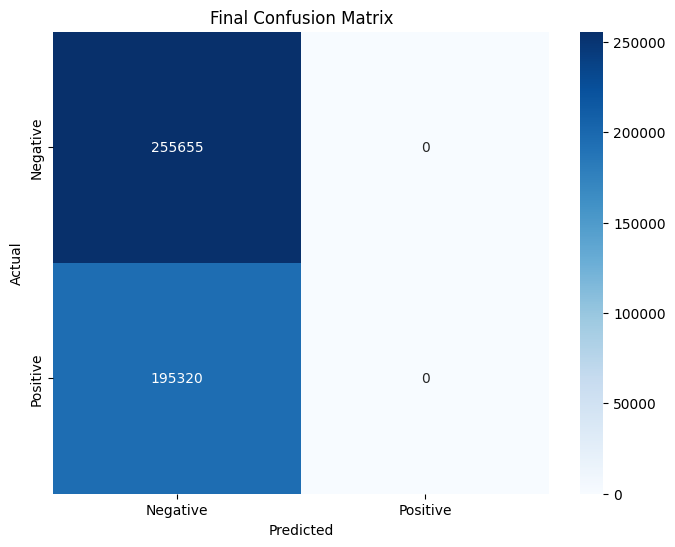

In [30]:
# Generate final confusion matrix and heatmap after all epochs
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Final Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
# plt.savefig("final_confusion_matrix.png")
plt.show()

In [31]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(y_true_all, y_pred_all, target_names=["Non-Fall", "Fall"])
print("Classification Report:\n", class_report)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

    Non-Fall       0.57      1.00      0.72    255655
        Fall       0.00      0.00      0.00    195320

    accuracy                           0.57    450975
   macro avg       0.28      0.50      0.36    450975
weighted avg       0.32      0.57      0.41    450975



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


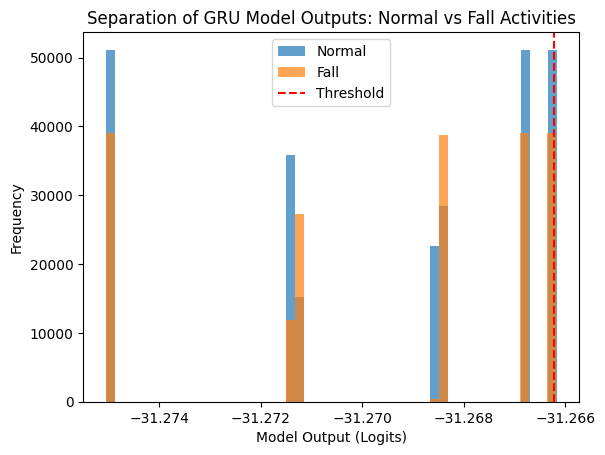

In [32]:
# Plot histograms to visualize the separation between normal and fall activities
plt.hist(normal_scores, bins=50, alpha=0.7, label="Normal")
plt.hist(fall_scores, bins=50, alpha=0.7, label="Fall")
plt.axvline(x=np.percentile(normal_scores, 95), color='r', linestyle='--', label="Threshold")
plt.xlabel("Model Output (Logits)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Separation of GRU Model Outputs: Normal vs Fall Activities")
plt.show()

### Tensorboard

In [33]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir "/kaggle/working/logs"

## Results and explanation 

### CNNs

I have obtain really different result from the two different way of splitting the dataset with the same models (GRU_SelfAttention and LSTM_SelfAttention).

#### - Classic split as 80% of the all dataset on Training, 20% on testing :
- We can see that i reached 97% accuracy with GRU
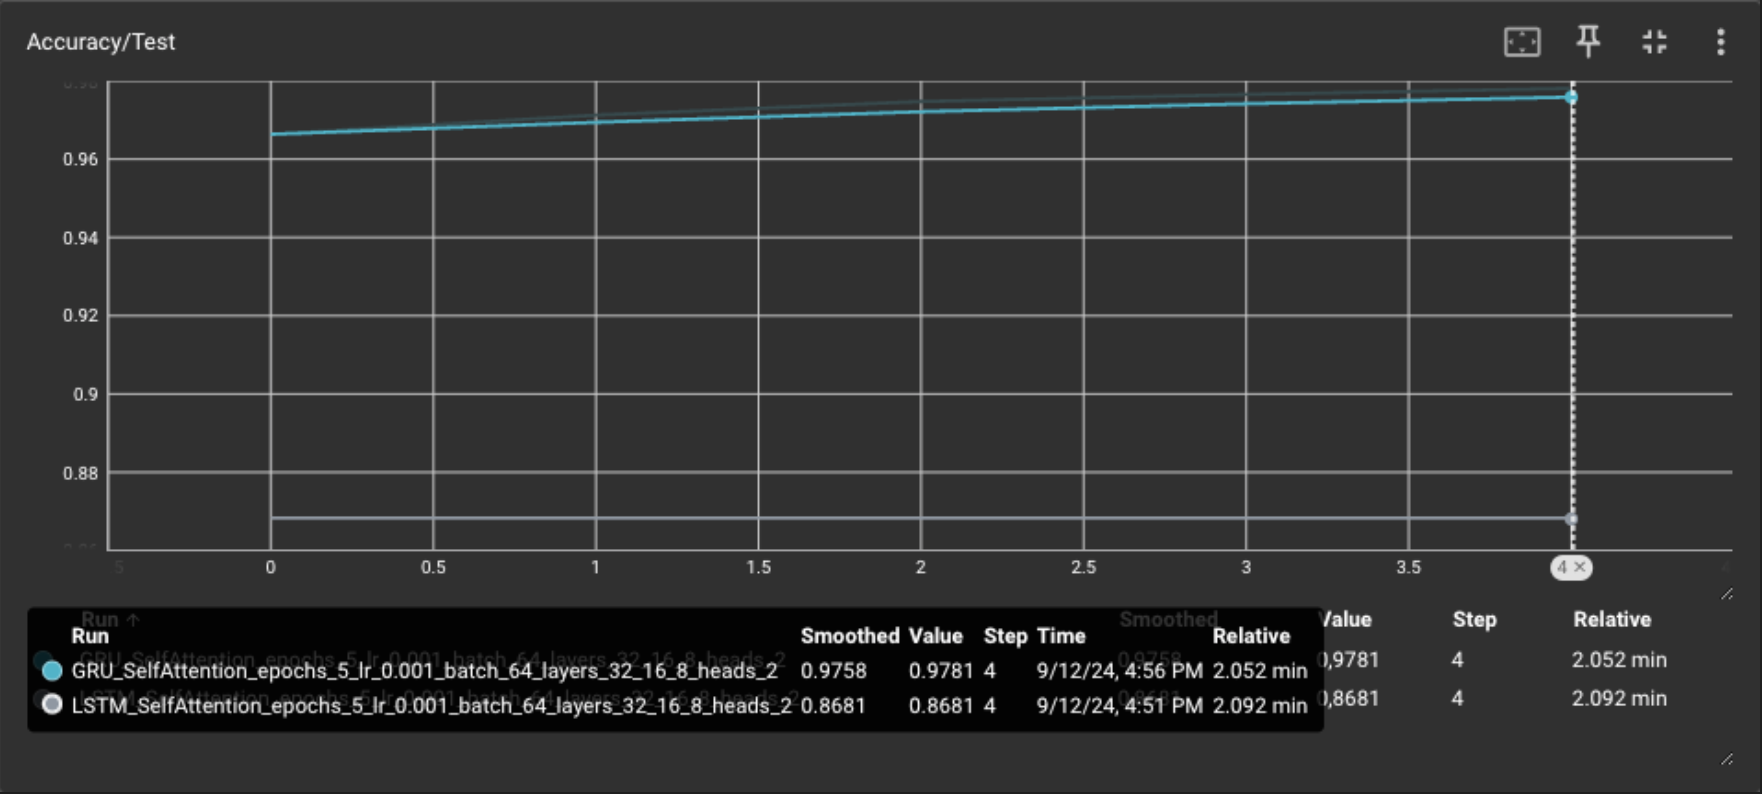


#### - Testset as : the all fall data + 20% of normal activities : 
I experimented with various approaches, but none successfully identified even a single fall activity. This has left me quite disappointed. Although the training set includes relatively few fall activities, I’m puzzled as to why the model performs so poorly compared to using different methods of splitting the dataset for training.


# Conclusion


I initially used Local Outlier Factor, which successfully addressed the problem and provided good results. However, the Variational Autoencoder was disappointing. I then experimented with more complex algorithms, but they only worked when using a data-splitting method that you didn’t recommend and which seemed less logical.